In [43]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/mdonato/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['array']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [44]:
import pandas

In [45]:
from tqdm import tqdm
import ttp
ttp.__file__

'/home/mdonato-fast/myDev/timetaggingplatform-7x7full/dataProcessing/libs/libttp/ttp/__init__.py'

In [46]:
#dorg=np.fromfile("/home/mdonato-fast/myDev/timetaggingplatform/dataReceiver/linux/"+"data/data-1626096281.889305.ttr",dtype=np.uint16)
#dorg=np.fromfile("/home/mdonato-fast/myDev/timetaggingplatform-small7x7-newfifo//dataReceiver/linux/"+"data/data-1626442644.739316.ttr",dtype=np.uint16)
dorg=np.fromfile("/home/mdonato-fast/myDev/timetaggingplatform-7x7full/dataReceiver/linux/data/data-1629443860.361080.ttr",dtype=np.uint16)

#dorg=np.fromfile("/mnt/DATA/data-1626098595.978965-100x100.ttr",dtype=np.uint16)

#dorg=np.fromfile("/home/mdonato/mdonato-fast/NEW-PROTOCOL_data-1624889234.113406.ttr",dtype=np.uint8) 
#dorg=dorg[dorg!=0b0111111111111111]
print(len(dorg))

13256892


In [47]:
c=0
for i in dorg[0:4000]:
    
    ID=(i & 0b0111_1111_0000_0000) // 0b0000_0001_0000_0000
    valids=(i & 0b1000_0000_0000_0000) >> 15
    data =(i & 0b0000_0000_1111_1111) 

    
    print('\n{0:016b}'.format(i), ID, "\t",c,"\t", valids, "\t",data,  end="" )
    #else:
    #    print(".",end="")
    if ID>23:
        continue
    if ID==124:
        print("<=== LASER")
        c=c+1            
    if ID==127:
        print("*")
        c=c+1        


1000010001001101 4 	 0 	 1 	 77
1000010101010010 5 	 0 	 1 	 82
1000011001010010 6 	 0 	 1 	 82
1000011101001010 7 	 0 	 1 	 74
1000100001010010 8 	 0 	 1 	 82
1000100101010111 9 	 0 	 1 	 87
1000101001010111 10 	 0 	 1 	 87
1000101101010101 11 	 0 	 1 	 85
1000110001010011 12 	 0 	 1 	 83
1000110101010110 13 	 0 	 1 	 86
1000111001010100 14 	 0 	 1 	 84
1000111101001110 15 	 0 	 1 	 78
1001000001011000 16 	 0 	 1 	 88
1001000101011000 17 	 0 	 1 	 88
1001001001010111 18 	 0 	 1 	 87
1001001101011010 19 	 0 	 1 	 90
1001010001011010 20 	 0 	 1 	 90
0001010100000000 21 	 0 	 0 	 0
0111110001111111 124 	 0 	 0 	 127
1111110100001100 125 	 0 	 1 	 12
1111111001110111 126 	 0 	 1 	 119
1111111110000011 127 	 0 	 1 	 131
1111110000101101 124 	 0 	 1 	 45
1111110100010001 125 	 0 	 1 	 17
1111111001110111 126 	 0 	 1 	 119
1111111110000011 127 	 0 	 1 	 131
0001001000000000 18 	 0 	 0 	 0
1001001100000000 19 	 0 	 1 	 0
1001010000000000 20 	 0 	 1 	 0
0001010100000000 21 	 0 	 0 	 0
1111110

In [48]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [49]:
%%cython
cimport numpy as np

import numpy as np
import cython

In [50]:
%%cython -a
cimport numpy as np
import numpy as np
from cpython cimport array
import array

def process(dataIn, CHANNELS=21):
    print(len(dataIn))
    cdef np.uint16_t MAXWORD=CHANNELS+5
    print("Channels:",CHANNELS)
    print("MAXWORD:",MAXWORD)
    
    dataIn=dataIn[dataIn!=0b0111_1111_1111_1111]
    ID=(dataIn & 0b0111_1111_0000_0000) // 0b0000_0001_0000_0000
    valids=(dataIn & 0b1000_0000_0000_0000) >> 15
    data =(dataIn & 0b0000_0000_1111_1111) 
    maxevents=np.count_nonzero(ID==127)+1
    
    print(maxevents)
    dataout = np.zeros((maxevents, MAXWORD*3),dtype= np.uint8)
    cdef np.uint8_t [:,:] dataout_view  = dataout
    

    
    cdef np.uint16_t  [:] dataIn_view=dataIn
    
    cdef np.uint64_t current_pointer 
    cdef np.uint64_t length = len(dataIn)
    
    cdef np.uint16_t [:] ID_view               = ID
    cdef np.uint16_t [:] valids_view           = valids
    cdef np.uint16_t [:] data_view             = data
    
    current_pointer = 0
    length=len(dataIn)
    for i in range(0,length):
        if (ID_view[i]<CHANNELS):
            dataout_view[current_pointer, ID_view[i] + MAXWORD*0 ] = ID_view[i]
            dataout_view[current_pointer, ID_view[i] + MAXWORD*1 ] = valids_view[i]
            dataout_view[current_pointer, ID_view[i] + MAXWORD*2 ] = data_view[i]
        elif (ID_view[i]==124): #Laser
            dataout_view[current_pointer, MAXWORD-4 + MAXWORD*0 ] = ID_view[i]
            dataout_view[current_pointer, MAXWORD-4 + MAXWORD*1 ] = valids_view[i]
            dataout_view[current_pointer, MAXWORD-4 + MAXWORD*2 ] = data_view[i]            
        elif (ID_view[i]==125): #pixel, low step
            dataout_view[current_pointer, MAXWORD-3 + MAXWORD*0 ] = ID_view[i]
            dataout_view[current_pointer, MAXWORD-3 + MAXWORD*1 ] = valids_view[i]
            dataout_view[current_pointer, MAXWORD-3 + MAXWORD*2 ] = data_view[i]
        elif (ID_view[i]==126): #scan,  middle step
            dataout_view[current_pointer, MAXWORD-2 + MAXWORD*0 ] = ID_view[i]
            dataout_view[current_pointer, MAXWORD-2 + MAXWORD*1 ] = valids_view[i]
            dataout_view[current_pointer, MAXWORD-2 + MAXWORD*2 ] = data_view[i]
        elif (ID_view[i]==127): #line,  high step
            dataout_view[current_pointer, MAXWORD-1 + MAXWORD*0 ] = ID_view[i]
            dataout_view[current_pointer, MAXWORD-1 + MAXWORD*1 ] = valids_view[i]
            dataout_view[current_pointer, MAXWORD-1 + MAXWORD*2 ] = data_view[i]

            current_pointer=current_pointer+1
    return dataout[:current_pointer]

In [51]:
CHANNELS=49
d=process(dorg, CHANNELS=CHANNELS)
d

13256892
Channels: 49
MAXWORD: 54
937632


array([[  0,   0,   0, ...,  12, 119, 131],
       [  0,   0,   0, ...,  17, 119, 131],
       [  0,   0,   0, ...,  59,   0, 128],
       ...,
       [  0,   1,   2, ...,  80,  92, 128],
       [  0,   1,   0, ...,  81,  92, 128],
       [  0,   0,   0, ...,  86,  92, 128]], dtype=uint8)

In [52]:
#  dheader = [
#         ("event", np.uint32),  # uint16_t event;   /H
#         ("step", np.ushort),  # uint16_t step     ; /H
#         ("t_L", np.ubyte),  # uint8_t  t_L	  ; /B
#         ("scan_enable", np.ubyte),  # uint8_t scan_enable     ; /B
#         ("line_enable", np.ubyte),  # uint8_t line_enable     ; /B
#         ("pixel_enable", np.ubyte),  # uint8_t pixel_enable    ; /B
#         ("valid_tdc_L", np.ubyte),  # uint8_t valid_tdc_L     ; /B
#         ("id_0", np.ubyte)  # uint8_t  id		     ; /B // must be in value 0
#     ]

#     # dpayload_single=[
#     #     ("event", np.ushort),       # 	uint16_t event;
#     #     ("t_C", np.ubyte),          # 	uint8_t  t_C     ;
#     #     ("t_B", np.ubyte),          # 	uint8_t  t_B     ;
#     #     ("t_A", np.ubyte),          # 	uint8_t  t_A     ;
#     #     ("useless", np.ubyte),      # 	uint8_t  useless	 ;
#     #     ("valid_tdc_C", np.ubyte),  # 	uint8_t  valid_tdc_C ;
#     #     ("valid_tdc_B", np.ubyte),  # 	uint8_t  valid_tdc_B ;
#     #     ("valid_tdc_A", np.ubyte),   # 	uint8_t  valid_tdc_A ;
#     #     ("id", np.ubyte)            # 	uint8_t  id		     ; /B // must be in value 0
#     # ]
#     NUMWORDS = 8
#     dpayload = []
#     for n in range(0, (NUMWORDS - 1)):
#         dpayload_single = [
#             ("event_" + str(n * 3), np.uint32),  # uint16_t event;
#             ("t_" + str(n * 3 + 2), np.ubyte),  # uint8_t  t_C     ;
#             ("t_" + str(n * 3 + 1), np.ubyte),  # uint8_t  t_B     ;
#             ("t_" + str(n * 3 + 0), np.ubyte),  # uint8_t  t_A     ;
#             ("useless_" + str(n), np.ubyte),  # uint8_t  useless	 ;
#             ("valid_tdc_" + str(n * 3 + 2), np.ubyte),  # uint8_t  valid_tdc_C ;
#             ("valid_tdc_" + str(n * 3 + 1), np.ubyte),  # uint8_t  valid_tdc_B ;
#             ("valid_tdc_" + str(n * 3 + 0), np.ubyte),  # uint8_t  valid_tdc_A ;
#             ("id_" + str(n + 1), np.ubyte)  # uint8_t  id		     ; /B // must be in value 0

In [53]:
df=[]

In [54]:
print("Z")

df=pandas.DataFrame(d, columns=["id_%d"%k for k in range(0,CHANNELS+5)] +
                               ["valid_tdc_%d"%k for k in range(0,CHANNELS+5)] +
                               ["t_%d"%k for k in range(0,CHANNELS+5)])
print("I")
d=[]
df.rename(inplace=True, columns={"valid_tdc_%d"%(CHANNELS+5-5): "valid_tdc_L_copy",
                                 "valid_tdc_%d"%(CHANNELS+5-4): "valid_tdc_L",
                                 "valid_tdc_%d"%(CHANNELS+5-3): "valid_%d"%(CHANNELS+5-3),
                                 "valid_tdc_%d"%(CHANNELS+5-2): "valid_%d"%(CHANNELS+5-2),
                                 "valid_tdc_%d"%(CHANNELS+5-1): "valid_%d"%(CHANNELS+5-1),
                                 "t_%d"%(CHANNELS+5-5): "t_L_copy",
                                 "t_%d"%(CHANNELS+5-4): "t_L",
                                 "t_%d"%(CHANNELS+5-3): "data_%d"%(CHANNELS+5-3),
                                 "t_%d"%(CHANNELS+5-2): "data_%d"%(CHANNELS+5-2),
                                 "t_%d"%(CHANNELS+5-1): "data_%d"%(CHANNELS+5-1)                  
                  })


Z
I


In [55]:
df["valid_tdc_L"].sum()

566388

In [56]:
for i in df.keys():
    print(i," ",end="")

id_0  id_1  id_2  id_3  id_4  id_5  id_6  id_7  id_8  id_9  id_10  id_11  id_12  id_13  id_14  id_15  id_16  id_17  id_18  id_19  id_20  id_21  id_22  id_23  id_24  id_25  id_26  id_27  id_28  id_29  id_30  id_31  id_32  id_33  id_34  id_35  id_36  id_37  id_38  id_39  id_40  id_41  id_42  id_43  id_44  id_45  id_46  id_47  id_48  id_49  id_50  id_51  id_52  id_53  valid_tdc_0  valid_tdc_1  valid_tdc_2  valid_tdc_3  valid_tdc_4  valid_tdc_5  valid_tdc_6  valid_tdc_7  valid_tdc_8  valid_tdc_9  valid_tdc_10  valid_tdc_11  valid_tdc_12  valid_tdc_13  valid_tdc_14  valid_tdc_15  valid_tdc_16  valid_tdc_17  valid_tdc_18  valid_tdc_19  valid_tdc_20  valid_tdc_21  valid_tdc_22  valid_tdc_23  valid_tdc_24  valid_tdc_25  valid_tdc_26  valid_tdc_27  valid_tdc_28  valid_tdc_29  valid_tdc_30  valid_tdc_31  valid_tdc_32  valid_tdc_33  valid_tdc_34  valid_tdc_35  valid_tdc_36  valid_tdc_37  valid_tdc_38  valid_tdc_39  valid_tdc_40  valid_tdc_41  valid_tdc_42  valid_tdc_43  valid_tdc_44  valid_tdc_45

In [57]:
print("II")
df["pixel_enable"] = np.right_shift(np.bitwise_and(df["data_%d"%(CHANNELS+5-3)] , 0b1000_0000), 7)#// 0b1000_0000
df["scan_enable"]  = np.right_shift(np.bitwise_and(df["data_%d"%(CHANNELS+5-2)] , 0b1000_0000), 7)#// 0b1000_0000
df["line_enable"]  = np.right_shift(np.bitwise_and(df["data_%d"%(CHANNELS+5-1)] , 0b1000_0000), 7)#// 0b1000_0000
print("III")
step_C =  np.bitwise_and(df["data_%d"%(CHANNELS+5-3)], 0b0111_1111)
step_B =  np.bitwise_and(df["data_%d"%(CHANNELS+5-2)], 0b0111_1111)
step_A =  np.bitwise_and(df["data_%d"%(CHANNELS+5-1)], 0b0111_1111)
print("IV")
df["step"]=np.left_shift(step_A.astype(np.uint16),14)+np.left_shift(step_B.astype(np.uint16),7)+step_C.astype(np.uint16)
df.keys()

II
III
IV


Index(['id_0', 'id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7', 'id_8',
       'id_9',
       ...
       't_48', 't_L_copy', 't_L', 'data_51', 'data_52', 'data_53',
       'pixel_enable', 'scan_enable', 'line_enable', 'step'],
      dtype='object', length=166)

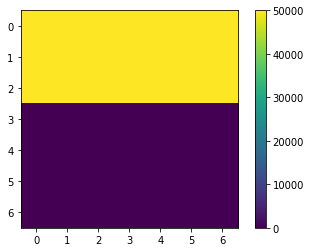

In [58]:
valids=df[["valid_tdc_%d"%i for i in range(0,CHANNELS)]].sum()
valids=asarray(valids).reshape((7,7))
imshow(valids,vmax=0.05e6)
colorbar()

In [59]:

# matrixTotalPhoton=zeros((5,5))
# matrixTotalPhoton[0,1]=df['valid_tdc_0'].sum()
# matrixTotalPhoton[0,2]=df['valid_tdc_1'].sum()
# matrixTotalPhoton[0,3]=df['valid_tdc_2'].sum()

# matrixTotalPhoton[1,0]=df['valid_tdc_3'].sum()
# matrixTotalPhoton[1,1]=df['valid_tdc_4'].sum()
# matrixTotalPhoton[1,2]=df['valid_tdc_5'].sum()
# matrixTotalPhoton[1,3]=df['valid_tdc_6'].sum()
# matrixTotalPhoton[1,4]=df['valid_tdc_7'].sum()

# matrixTotalPhoton[2,0]=df['valid_tdc_8'].sum()
# matrixTotalPhoton[2,1]=df['valid_tdc_9'].sum()
# matrixTotalPhoton[2,2]=df['valid_tdc_10'].sum()
# matrixTotalPhoton[2,3]=df['valid_tdc_11'].sum()
# matrixTotalPhoton[2,4]=df['valid_tdc_12'].sum()
# matrixTotalPhoton[3,0]=df['valid_tdc_13'].sum()
# matrixTotalPhoton[3,1]=df['valid_tdc_14'].sum()

# matrixTotalPhoton[3,2]=df['valid_tdc_15'].sum()
# matrixTotalPhoton[3,3]=df['valid_tdc_16'].sum()
# matrixTotalPhoton[3,4]=df['valid_tdc_17'].sum()

# matrixTotalPhoton[4,1]=df['valid_tdc_18'].sum()
# matrixTotalPhoton[4,2]=df['valid_tdc_19'].sum()
# matrixTotalPhoton[4,3]=df['valid_tdc_20'].sum()

# figure,imshow(matrixTotalPhoton/np.max(matrixTotalPhoton)*100)
# print(matrixTotalPhoton/np.max(matrixTotalPhoton)*100)
# colorbar()


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

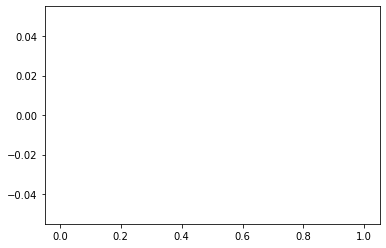

In [60]:
ch=37
hist(df[df["valid_tdc_%d"%ch]==1]["t_%d"%ch])

(array([59522., 38287., 36487., 37951., 44744., 39408., 34676., 40572.,
        28707., 49268.]),
 array([ 0. ,  9.4, 18.8, 28.2, 37.6, 47. , 56.4, 65.8, 75.2, 84.6, 94. ]),
 <BarContainer object of 10 artists>)

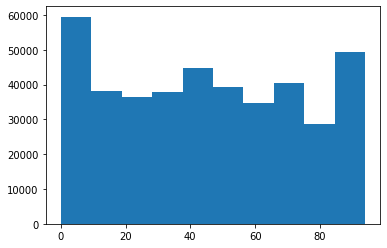

In [61]:
hist(df[df["valid_tdc_10"]==1]["t_10"])

In [62]:
import ttp

In [63]:
ttp.__file__

'/home/mdonato-fast/myDev/timetaggingplatform-7x7full/dataProcessing/libs/libttp/ttp/__init__.py'

In [64]:
df[df["t_21"]!=0]

,id_0,id_1,id_2,id_3,id_4,id_5,id_6,id_7,id_8,id_9,...,t_48,t_L_copy,t_L,data_51,data_52,data_53,pixel_enable,scan_enable,line_enable,step


In [65]:
ttp.convertFromPandasDataFrame(df,filenameOutputHDF5='/tmp/prova',list_of_channels=np.arange(0,49))

Calculate rates 
Calculate cumulative step 
Add cumulativeStep


Current frame: 0 	:  40%|███▉      | 375040/937631 [00:00<00:00, 3034773.79it/s]

Acquisition lasted:  1.991529375 s
Scan_enable 0.0 ratio 0.0 rate 0.0
line_enable 463975.0 ratio 0.4948375213703472 rate 232974.2186203003
pixel_enable 12138.0 ratio 0.012945391097350663 rate 6094.8134395456755
Laser 566388.0 ratio 0.6040627922924904 rate 284398.51659230486
Calculate totalphotons 
kC4<=== 45.0
sysclk_ps<=== 4166.666666666667
kC4<=== 44.80286738351255
Start process
Start analysisForImg
Arrays copied into analysisForImg


Current frame: 0 	: : 946976it [00:00, 2618648.16it/s]                          

Total Frame: 0



  0%|          | 0/49 [00:00<?, ?it/s]

New HDF5 written
total_photon        uint8
cumulative_step     int64
arr_px             uint16
arr_px_corr        uint16
arr_py             uint16
arr_frame          uint16
dtype: object
Start conversion of 0 channel
t_0 valid_tdc_0
..




  0%|          | 0/924696 [00:00<?, ?it/s]

 77%|███████▋  | 711942/924696 [00:00<00:00, 7040317.01it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_0"



  2%|▏         | 1/49 [00:00<00:40,  1.19it/s]

t_0      int16
t_L      int16
dS_0    uint16
dtype: object
Start conversion of 1 channel
t_1 valid_tdc_1
..





  4%|▍         | 2/49 [00:01<00:37,  1.26it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_1"
t_1      int16
t_L      int16
dS_1    uint16
dtype: object
Start conversion of 2 channel
t_2 valid_tdc_2
..






933846it [00:01, 569217.25it/s]                             
815070it [00:00, 944952.33it/s]           
803960it [00:00, 5731469.29it/s]          

  6%|▌         | 3/49 [00:02<00:35,  1.29it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_2"
t_2      int16
t_L      int16
dS_2    uint16
dtype: object
Start conversion of 3 channel
t_3 valid_tdc_3
..




  0%|          | 0/788217 [00:00<?, ?it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_3"



  8%|▊         | 4/49 [00:03<00:34,  1.31it/s]

t_3      int16
t_L      int16
dS_3    uint16
dtype: object
Start conversion of 4 channel
t_4 valid_tdc_4
..





 10%|█         | 5/49 [00:03<00:32,  1.34it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_4"
t_4      int16
t_L      int16
dS_4    uint16
dtype: object
Start conversion of 5 channel
t_5 valid_tdc_5
..






  0%|          | 0/802093 [00:00<?, ?it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_5"



 12%|█▏        | 6/49 [00:04<00:31,  1.34it/s]

t_5      int16
t_L      int16
dS_5    uint16
dtype: object
Start conversion of 6 channel
t_6 valid_tdc_6
..







796082it [00:02, 343595.43it/s]           
831836it [00:01, 533670.70it/s]           
810020it [00:00, 944721.06it/s]           
811333it [00:00, 6505678.40it/s]          


Data ready, conversion to array
Adding keys to HDF5...  "ch_6"



 14%|█▍        | 7/49 [00:05<00:31,  1.34it/s]

t_6      int16
t_L      int16
dS_6    uint16
dtype: object
Start conversion of 7 channel
t_7 valid_tdc_7
..




  0%|          | 0/834394 [00:00<?, ?it/s]

 82%|████████▏ | 684126/834394 [00:00<00:00, 6830485.75it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_7"



 16%|█▋        | 8/49 [00:05<00:30,  1.32it/s]

t_7      int16
t_L      int16
dS_7    uint16
dtype: object
Start conversion of 8 channel
t_8 valid_tdc_8
..





  0%|          | 0/801361 [00:00<?, ?it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_8"



 18%|█▊        | 9/49 [00:06<00:29,  1.34it/s]

t_8      int16
t_L      int16
dS_8    uint16
dtype: object
Start conversion of 9 channel
t_9 valid_tdc_9
..






 20%|██        | 10/49 [00:07<00:28,  1.36it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_9"
t_9      int16
t_L      int16
dS_9    uint16
dtype: object
Start conversion of 10 channel
t_10 valid_tdc_10
..







  0%|          | 0/791872 [00:00<?, ?it/s]




842643it [00:02, 359645.70it/s]                             
809313it [00:01, 508993.98it/s]           
793961it [00:00, 925007.20it/s]           
799718it [00:00, 5087631.84it/s]                            

 22%|██▏       | 11/49 [00:08<00:27,  1.36it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_10"
t_10      int16
t_L       int16
dS_10    uint16
dtype: object
Start conversion of 11 channel
t_11 valid_tdc_11
..




 24%|██▍       | 12/49 [00:08<00:27,  1.36it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_11"
t_11      int16
t_L       int16
dS_11    uint16
dtype: object
Start conversion of 12 channel
t_12 valid_tdc_12
..





 27%|██▋       | 13/49 [00:09<00:26,  1.37it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_12"
t_12      int16
t_L       int16
dS_12    uint16
dtype: object
Start conversion of 13 channel
t_13 valid_tdc_13
..






 29%|██▊       | 14/49 [00:10<00:25,  1.36it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_13"
t_13      int16
t_L       int16
dS_13    uint16
dtype: object
Start conversion of 14 channel
t_14 valid_tdc_14
..







810020it [00:02, 347286.39it/s]           
814262it [00:01, 498434.96it/s]           
807697it [00:00, 917537.33it/s]           
811737it [00:00, 5650447.92it/s]          


Data ready, conversion to array
Adding keys to HDF5...  "ch_14"



 31%|███       | 15/49 [00:11<00:25,  1.31it/s]

t_14      int16
t_L       int16
dS_14    uint16
dtype: object
Start conversion of 15 channel
t_15 valid_tdc_15
..




 33%|███▎      | 16/49 [00:11<00:24,  1.34it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_15"
t_15      int16
t_L       int16
dS_15    uint16
dtype: object
Start conversion of 16 channel
t_16 valid_tdc_16
..





  0%|          | 0/789351 [00:00<?, ?it/s]


 35%|███▍      | 17/49 [00:12<00:24,  1.33it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_16"
t_16      int16
t_L       int16
dS_16    uint16
dtype: object
Start conversion of 17 channel
t_17 valid_tdc_17
..






 37%|███▋      | 18/49 [00:13<00:23,  1.35it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_17"
t_17      int16
t_L       int16
dS_17    uint16
dtype: object
Start conversion of 18 channel
t_18 valid_tdc_18
..







827796it [00:02, 358563.90it/s]           
797193it [00:01, 500123.29it/s]                             
793961it [00:00, 965212.89it/s]           
798708it [00:00, 6736628.21it/s]          

 39%|███▉      | 19/49 [00:14<00:22,  1.36it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_18"
t_18      int16
t_L       int16
dS_18    uint16
dtype: object
Start conversion of 19 channel
t_19 valid_tdc_19
..




 41%|████      | 20/49 [00:14<00:21,  1.38it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_19"
t_19      int16
t_L       int16
dS_19    uint16
dtype: object
Start conversion of 20 channel
t_20 valid_tdc_20
..





 43%|████▎     | 21/49 [00:15<00:19,  1.40it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_20"
t_20      int16
t_L       int16
dS_20    uint16
dtype: object
Start conversion of 21 channel
t_21 valid_tdc_21
..






 45%|████▍     | 22/49 [00:15<00:16,  1.68it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_21"
t_21      int16
t_L       int16
dS_21    uint16
dtype: object
Start conversion of 22 channel
t_22 valid_tdc_22
..







 47%|████▋     | 23/49 [00:16<00:13,  1.94it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_22"
t_22      int16
t_L       int16
dS_22    uint16
dtype: object
Start conversion of 23 channel
t_23 valid_tdc_23
..








 49%|████▉     | 24/49 [00:16<00:11,  2.16it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_23"
t_23      int16
t_L       int16
dS_23    uint16
dtype: object
Start conversion of 24 channel
t_24 valid_tdc_24
..









  0%|          | 0/566388 [00:00<?, ?it/s]
Current frame: 0 	: : 946976it [00:17, 2618648.16it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_24"
t_24      int16
t_L       int16
dS_24    uint16
dtype: object
Start conversion of 25 channel
t_25 valid_tdc_25
..










 53%|█████▎    | 26/49 [00:17<00:09,  2.50it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_25"
t_25      int16
t_L       int16
dS_25    uint16
dtype: object
Start conversion of 26 channel
t_26 valid_tdc_26
..











 55%|█████▌    | 27/49 [00:17<00:08,  2.60it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_26"
t_26      int16
t_L       int16
dS_26    uint16
dtype: object
Start conversion of 27 channel
t_27 valid_tdc_27
..












 57%|█████▋    | 28/49 [00:17<00:07,  2.70it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_27"
t_27      int16
t_L       int16
dS_27    uint16
dtype: object
Start conversion of 28 channel
t_28 valid_tdc_28
..













 59%|█████▉    | 29/49 [00:18<00:07,  2.83it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_28"
t_28      int16
t_L       int16
dS_28    uint16
dtype: object
Start conversion of 29 channel
t_29 valid_tdc_29
..














 61%|██████    | 30/49 [00:18<00:06,  2.93it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_29"
t_29      int16
t_L       int16
dS_29    uint16
dtype: object
Start conversion of 30 channel
t_30 valid_tdc_30
..















779720it [00:04, 184179.27it/s]           
784164it [00:03, 220650.02it/s]           
571963it [00:02, 191798.92it/s]           
571963it [00:02, 214524.61it/s]           
571963it [00:02, 247527.95it/s]           
571963it [00:01, 292025.77it/s]           
571963it [00:01, 351722.15it/s]           
571963it [00:01, 446523.15it/s]           
571963it [00:00, 606771.57it/s]           
571963it [00:00, 907728.52it/s]           
571963it [00:00, 1800817.99it/s]          
 63%|██████▎   | 31/49 [00:18<00:06,  2.98it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_30"
t_30      int16
t_L       int16
dS_30    uint16
dtype: object
Start conversion of 31 channel
t_31 valid_tdc_31
..




 65%|██████▌   | 32/49 [00:19<00:05,  3.04it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_31"
t_31      int16
t_L       int16
dS_31    uint16
dtype: object
Start conversion of 32 channel
t_32 valid_tdc_32
..





 67%|██████▋   | 33/49 [00:19<00:05,  2.95it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_32"
t_32      int16
t_L       int16
dS_32    uint16
dtype: object
Start conversion of 33 channel
t_33 valid_tdc_33
..






 69%|██████▉   | 34/49 [00:19<00:04,  3.02it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_33"
t_33      int16
t_L       int16
dS_33    uint16
dtype: object
Start conversion of 34 channel
t_34 valid_tdc_34
..







 71%|███████▏  | 35/49 [00:20<00:04,  2.98it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_34"
t_34      int16
t_L       int16
dS_34    uint16
dtype: object
Start conversion of 35 channel
t_35 valid_tdc_35
..








 73%|███████▎  | 36/49 [00:20<00:04,  2.95it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_35"
t_35      int16
t_L       int16
dS_35    uint16
dtype: object
Start conversion of 36 channel
t_36 valid_tdc_36
..









 76%|███████▌  | 37/49 [00:20<00:03,  3.01it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_36"
t_36      int16
t_L       int16
dS_36    uint16
dtype: object
Start conversion of 37 channel
t_37 valid_tdc_37
..










 78%|███████▊  | 38/49 [00:21<00:03,  3.06it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_37"
t_37      int16
t_L       int16
dS_37    uint16
dtype: object
Start conversion of 38 channel
t_38 valid_tdc_38
..











 80%|███████▉  | 39/49 [00:21<00:03,  3.10it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_38"
t_38      int16
t_L       int16
dS_38    uint16
dtype: object
Start conversion of 39 channel
t_39 valid_tdc_39
..












 82%|████████▏ | 40/49 [00:21<00:02,  3.12it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_39"
t_39      int16
t_L       int16
dS_39    uint16
dtype: object
Start conversion of 40 channel
t_40 valid_tdc_40
..













 84%|████████▎ | 41/49 [00:22<00:02,  3.05it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_40"
t_40      int16
t_L       int16
dS_40    uint16
dtype: object
Start conversion of 41 channel
t_41 valid_tdc_41
..














 86%|████████▌ | 42/49 [00:22<00:02,  2.97it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_41"
t_41      int16
t_L       int16
dS_41    uint16
dtype: object
Start conversion of 42 channel
t_42 valid_tdc_42
..
















 88%|████████▊ | 43/49 [00:22<00:02,  2.94it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_42"
t_42      int16
t_L       int16
dS_42    uint16
dtype: object
Start conversion of 43 channel
t_43 valid_tdc_43
..

















 90%|████████▉ | 44/49 [00:23<00:01,  2.97it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_43"
t_43      int16
t_L       int16
dS_43    uint16
dtype: object
Start conversion of 44 channel
t_44 valid_tdc_44
..


















 92%|█████████▏| 45/49 [00:23<00:01,  2.95it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_44"
t_44      int16
t_L       int16
dS_44    uint16
dtype: object
Start conversion of 45 channel
t_45 valid_tdc_45
..



















 94%|█████████▍| 46/49 [00:23<00:01,  2.95it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_45"
t_45      int16
t_L       int16
dS_45    uint16
dtype: object
Start conversion of 46 channel
t_46 valid_tdc_46
..




















 96%|█████████▌| 47/49 [00:24<00:00,  3.00it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_46"
t_46      int16
t_L       int16
dS_46    uint16
dtype: object
Start conversion of 47 channel
t_47 valid_tdc_47
..





















 ... (more hidden) ...


















571963it [00:05, 107386.74it/s]           
571963it [00:04, 115216.11it/s]           
571963it [00:04, 122967.68it/s]           
571963it [00:04, 132801.34it/s]           
571963it [00:03, 143743.69it/s]           
571963it [00:03, 156960.35it/s]           
571963it [00:03, 171753.66it/s]           
571963it [00:03, 189588.86it/s]           
571963it [00:02, 211453.35it/s]           
571963it [00:02, 242338.46it/s]           
571963it [00:02, 285440.67it/s]           
571963it [00:01, 341488.15it/s]           
571963it [00:01, 431517.36it/s]           
571963it [00:00, 581868.47it/s]           
571963it [00:00, 890266.43it/s]           
571963it [00:00, 1766889.17it/s]          

 98%|█████████▊| 48/49 [00:24<00:00,  2.98it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_47"
t_47      int16
t_L       int16
dS_47    uint16
dtype: object
Start conversion of 48 channel
t_48 valid_tdc_48
..





100%|██████████| 49/49 [00:24<00:00,  1.97it/s]

Data ready, conversion to array
Adding keys to HDF5...  "ch_48"
t_48      int16
t_L       int16
dS_48    uint16
dtype: object
Data saved:  /tmp/prova


{'mean_list': [], 'sigma_list': [], 'filenameH5': '/tmp/prova'}

In [66]:
myReturn={}
myReturn['filenameH5']="/tmp/prova"
nchannel=49
sysclk_MHz=240.  # FPGA system clock (MHz)
laser_MHz=40.    # Laser repetition rate (MHz)
laser_factor=1   # Adimensional number to account for laser actual repetiton frequency
nchannel = 49    # Number of active channels
kC4=48           # Time width of TCSPC histogram bin (picoseconds)

In [67]:
laser_MHz=laser_MHz*laser_factor
laser_Hz=laser_MHz*10**6
max_counter=2**16-1
sysclk_ps=1000000./sysclk_MHz #ps
print("SysClk ps:", sysclk_ps)
laser_ps=1000000./laser_MHz #ps
print("LaserClk ps:", laser_ps)
ratio=sysclk_MHz/laser_MHz
sysclk_ps=1e6/sysclk_MHz
laser_ps=1e6/laser_MHz
nbins=int(round(laser_ps/kC4))

SysClk ps: 4166.666666666667
LaserClk ps: 25000.0


571963it [00:00, 4896171.00it/s]          
Current frame: 0 	: : 946976it [00:25, 36832.52it/s]  
571963it [00:06, 92305.06it/s]            
571963it [00:00, 1048127.04it/s]


512 24


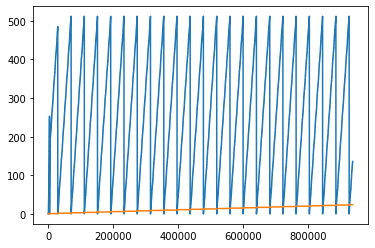

<Figure size 432x288 with 0 Axes>

<Figure size 864x864 with 0 Axes>

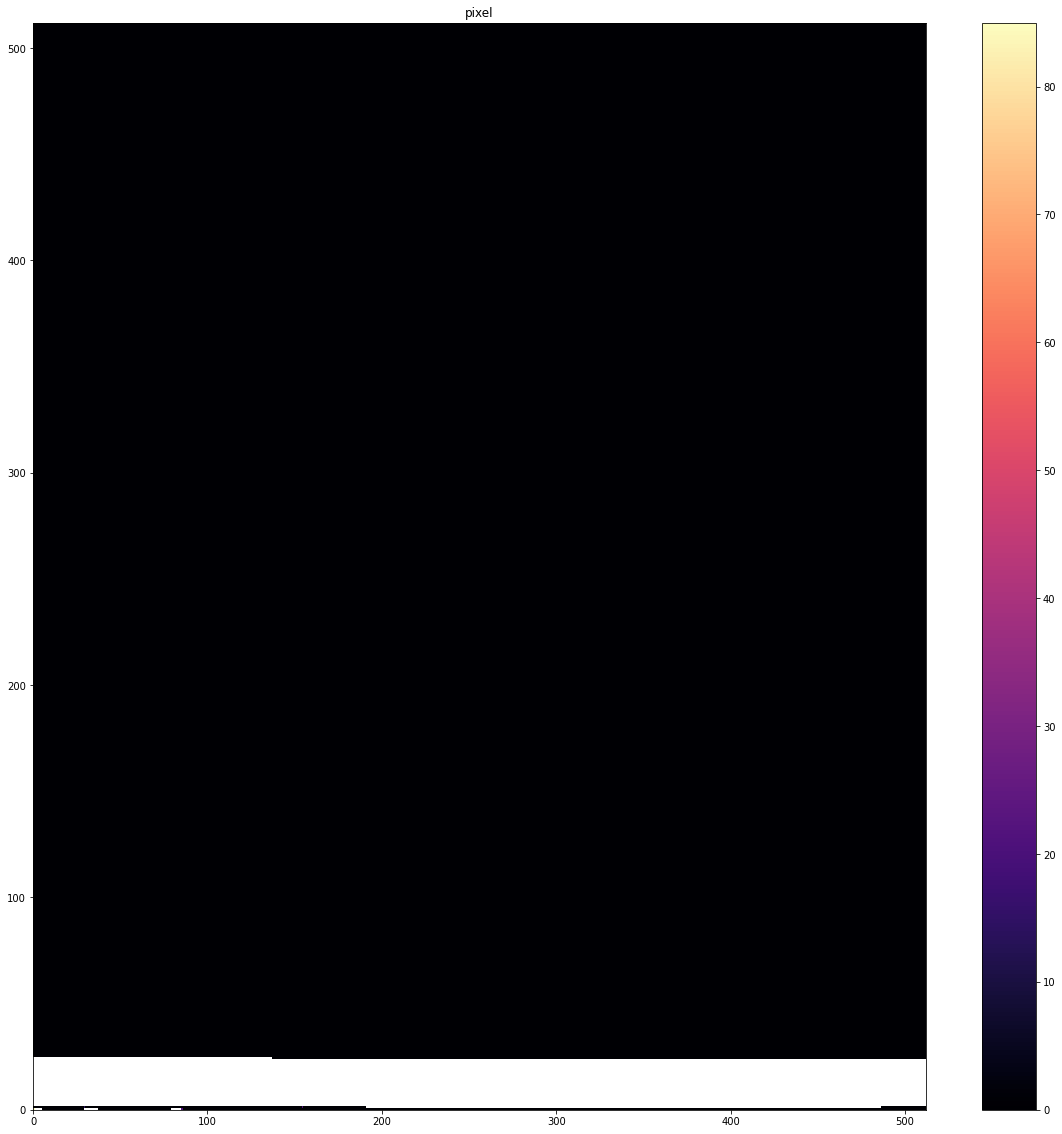

In [68]:
dfff=pandas.read_hdf(myReturn['filenameH5'],key="main")
plot(dfff["arr_px"])
plot(dfff["arr_py"])
print(dfff["arr_px"].max(), dfff["arr_py"].max())
figure()
alfa=max(dfff["arr_px"].max(), dfff["arr_py"].max())
figure(figsize(12,12))
#dred=df[(df["arr_frame"]!=0) & (df["arr_frame"]!=1)]
dred=dfff #[(dfff["arr#_frame"]==1)]
#dred=df
xx=dred["arr_px"]
yy=dred["arr_py"]
figure(figsize(20,20))
a=hist2d(xx,yy, weights=dred["total_photon"],bins=[alfa,alfa],range=[[0,alfa],[0,alfa]],cmin=0,cmax=100,cmap='magma')
#a=hist2d(xx,yy, weights=dred["total_photon"],bins=[numberOfPixelX,numberOfPixelY],range=[[0,numberOfPixelX],[0,numberOfPixelY]],cmin=0,cmax=8000)
colorbar()
title ('pixel')
savefig("/tmp/img.png")

(200.0, 250.0)

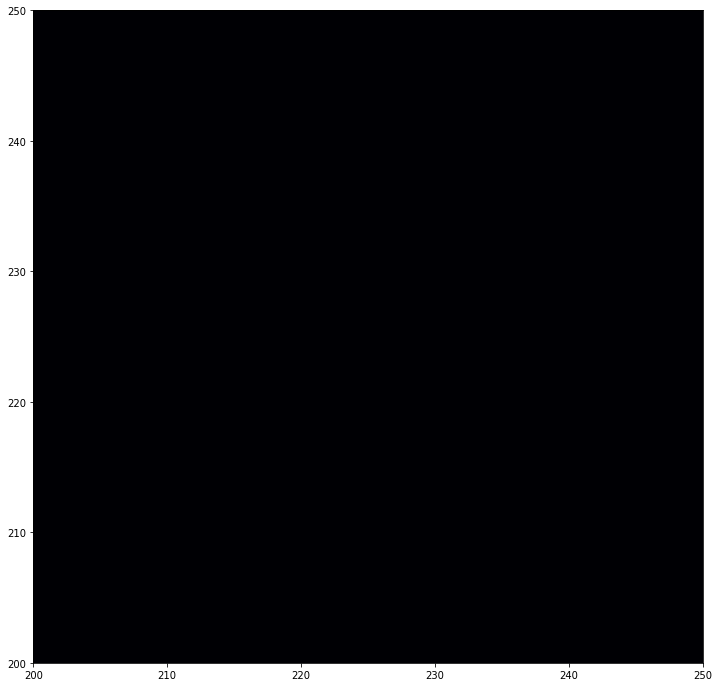

In [69]:
figure(figsize(12,12))
a=hist2d(xx,yy, weights=dred["total_photon"],bins=[alfa,alfa],range=[[0,alfa],[0,alfa]],cmin=0,cmax=1000,cmap='magma')
xlim(200,250)
ylim(200,250)


In [70]:
nchannel=21

# Timing calibration of data

In [71]:
calibDict=ttp.calculateCalibFromH5(filenameH5=myReturn['filenameH5'],    #the HDF5 file input
                                   listChannel=range(0,nchannel) #list of channel [0,mchannel]
                                   )

100%|██████████| 21/21 [00:02<00:00,  9.34it/s]


In [72]:
table_channels={}
for i in tqdm(range(nchannel)):
    #try:
        table_channels[i] = ttp.applyCalibDict(myReturn['filenameH5'],
                            channel=i, 
                            calibDict=calibDict)
#     except:
#         print("Error ", i)

100%|██████████| 21/21 [00:02<00:00,  8.80it/s]


# Not calibrated plot

<ipython-input-73-18d4581481b9>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


<Figure size 864x360 with 0 Axes>

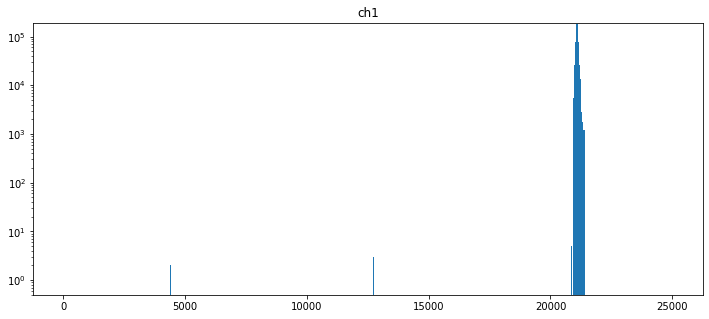

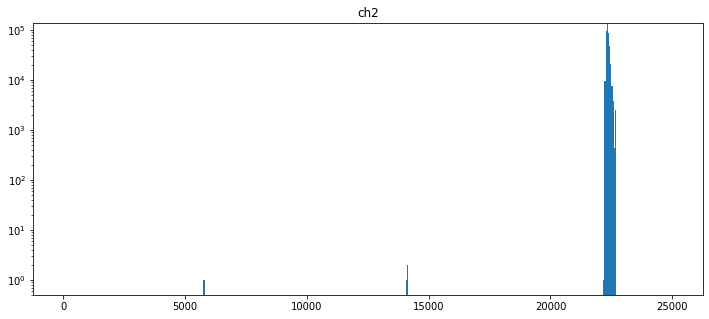

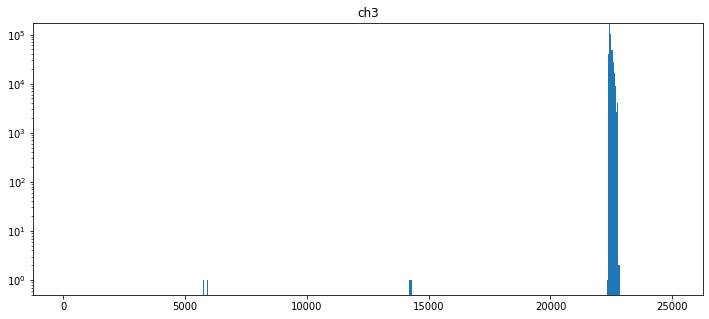

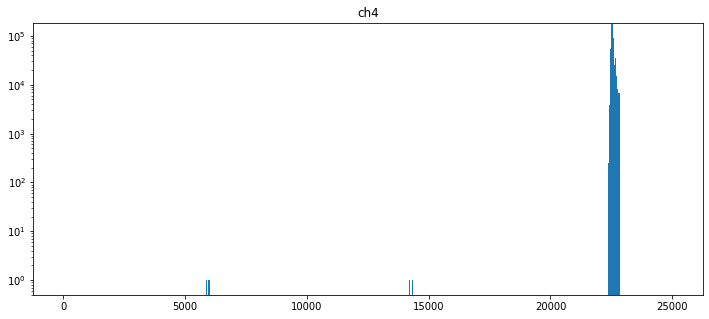

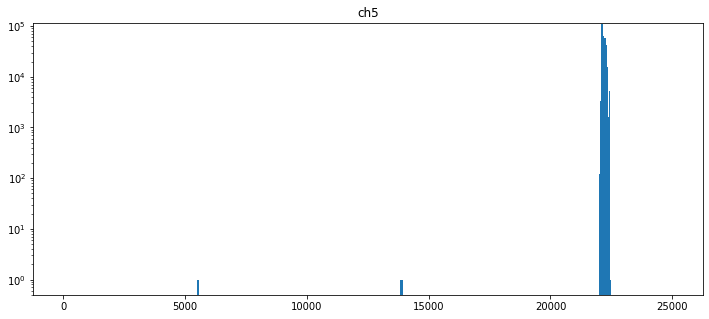

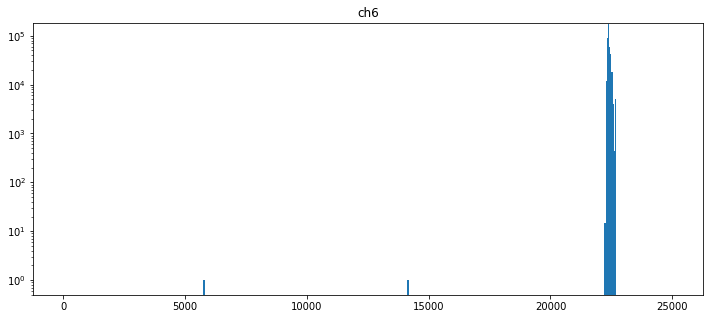

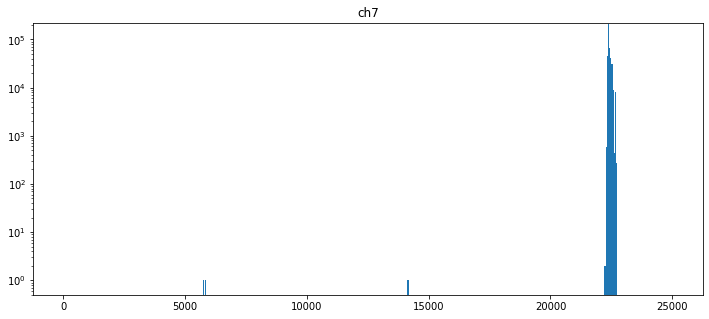

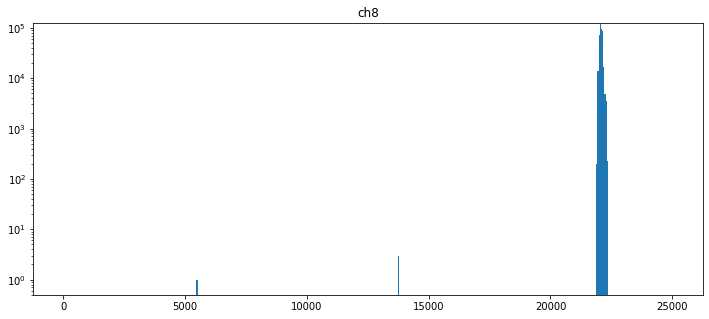

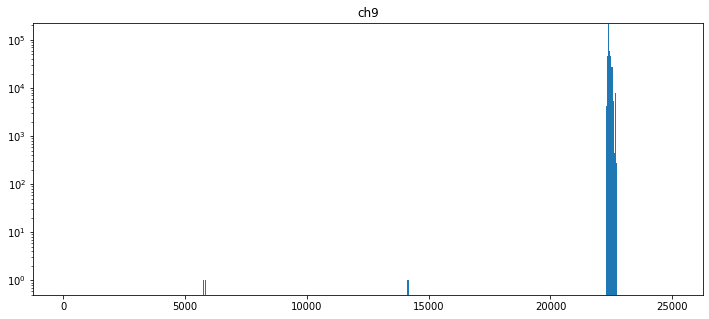

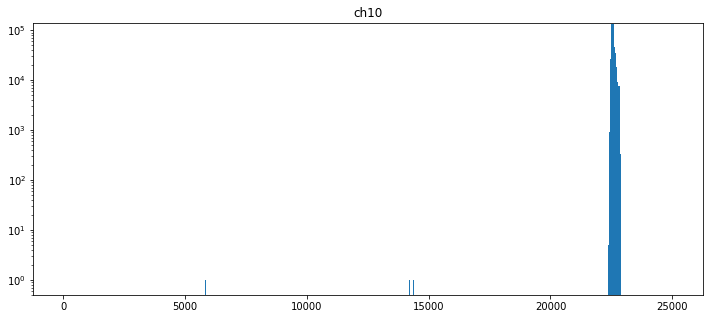

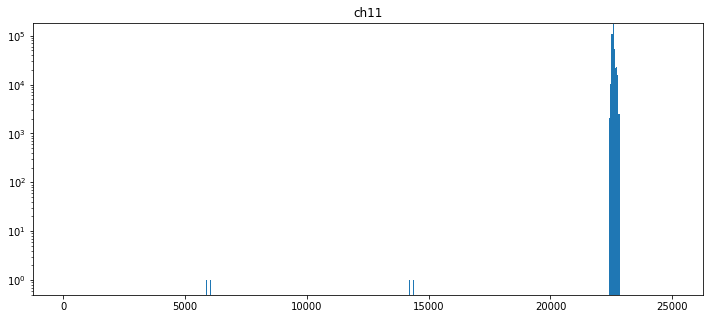

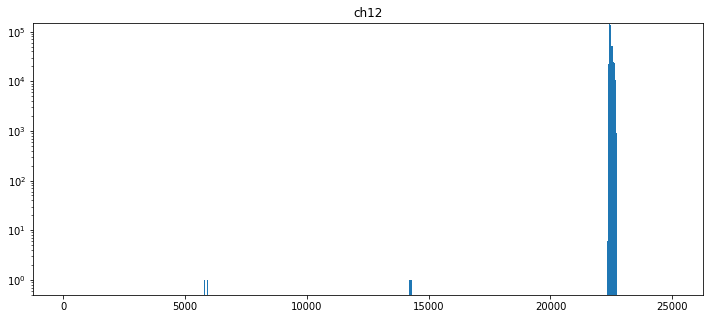

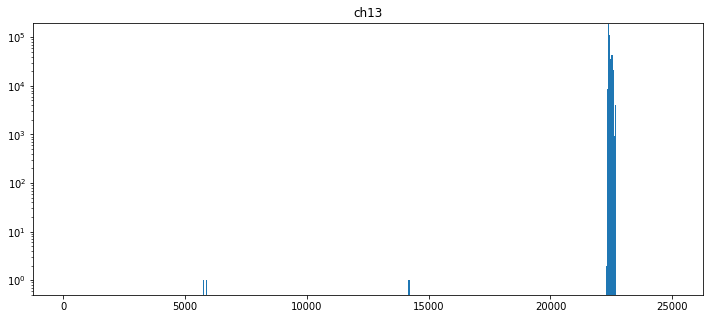

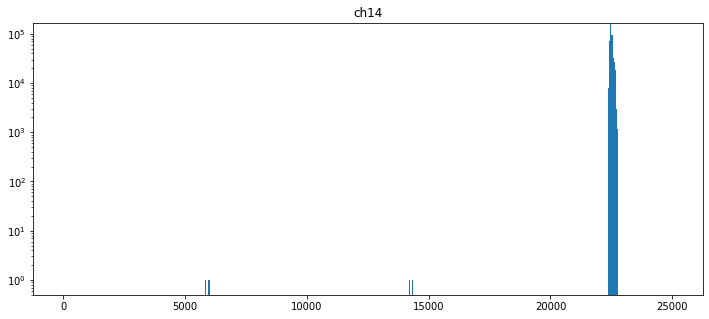

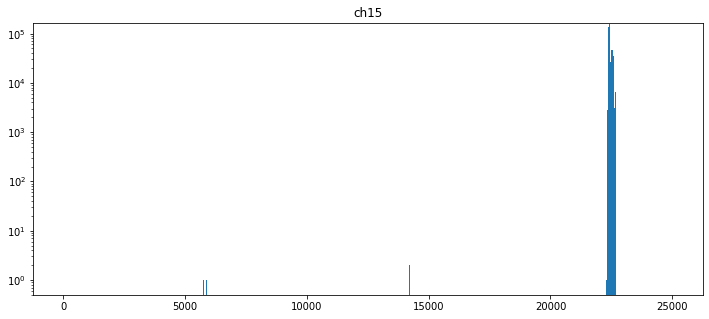

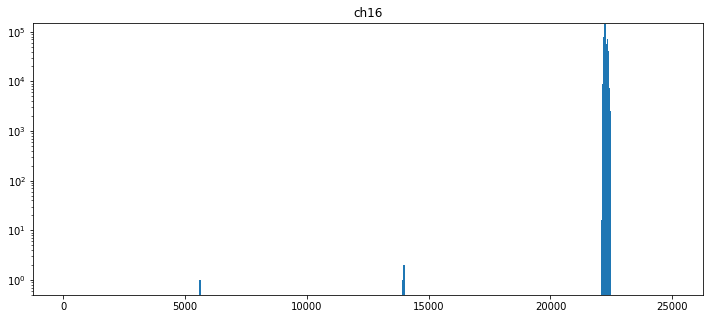

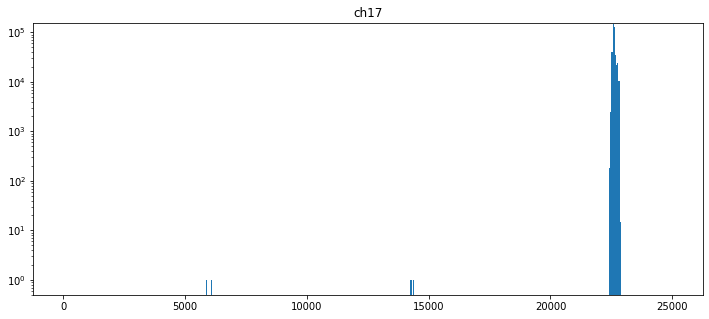

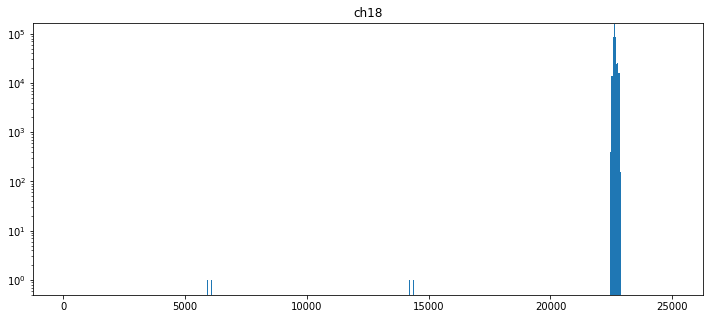

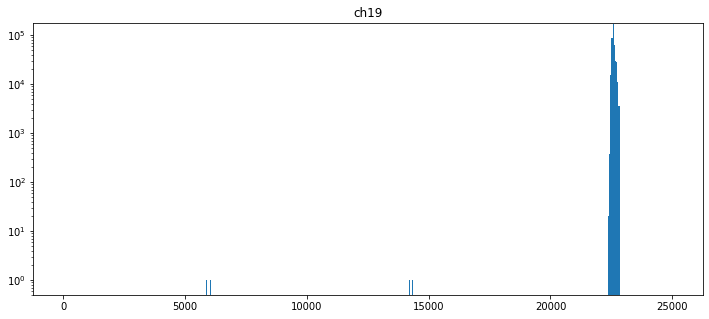

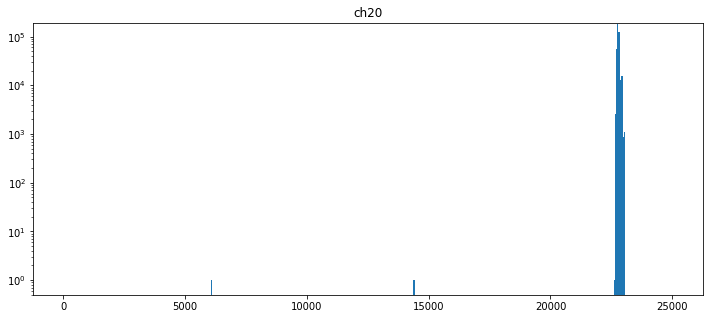

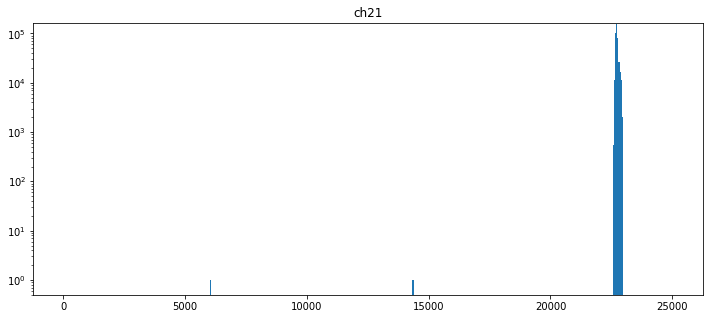

In [73]:
figure(figsize(12,5))

for i in range(0,nchannel):
#     try:
        t_L  = table_channels[i]["t_L"]
        t_CH = table_channels[i]["t_%d"%i]
        dS_0  = table_channels[i]["dS_%d"%i]
        dt=dS_0*sysclk_ps-(t_L-t_CH)*45.
        dt_mod=mod(dt, laser_ps)
        figure()
        #_=hist(dt, range=[-laser_ps,laser_ps*3],bins=nbins*4)
        _=hist(dt_mod, range=[0,laser_ps],bins=nbins)
        title('ch'+str(i+1))
        ylim(0.5,)
        yscale("log")
#     except:
#         pass
#         print("Error ", i)        

# TCSPC Histograms processing

In [74]:
dt_mod={}

for i in tqdm(range(nchannel)):
    try:
        df = table_channels[i]
        dt_mod[i] = np.mod(df['dt_'+str(i)],laser_ps)
    except:
        print("Error ", i)    

100%|██████████| 21/21 [00:00<00:00, 375.49it/s]


# TCSPC Histograms plots - calibrated

 67%|██████▋   | 14/21 [00:00<00:00, 64.07it/s]<ipython-input-75-21d528199553>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
100%|██████████| 21/21 [00:00<00:00, 148.36it/s]


<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

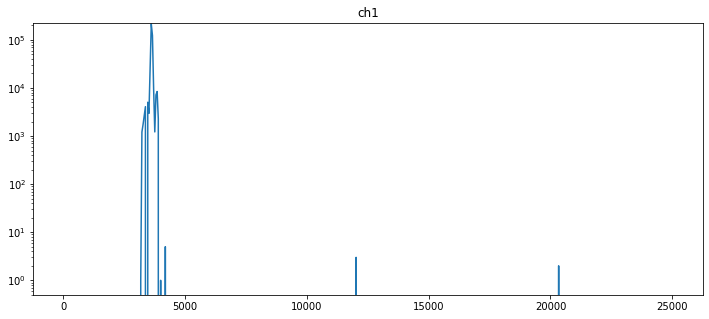

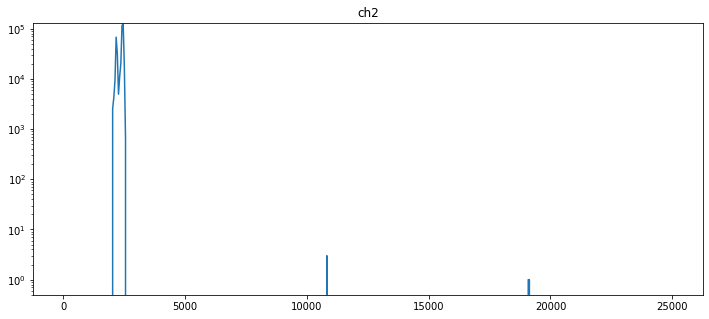

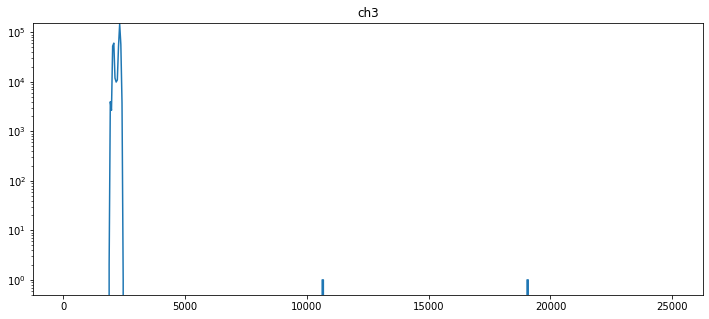

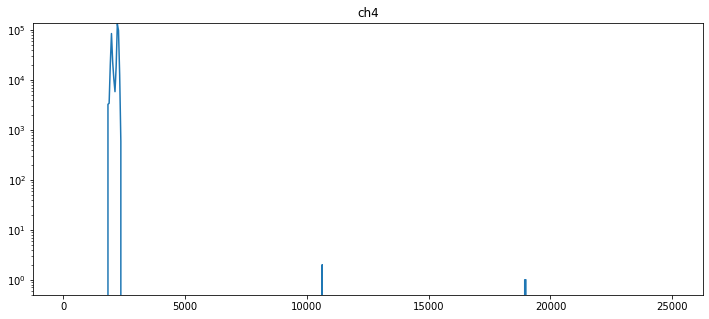

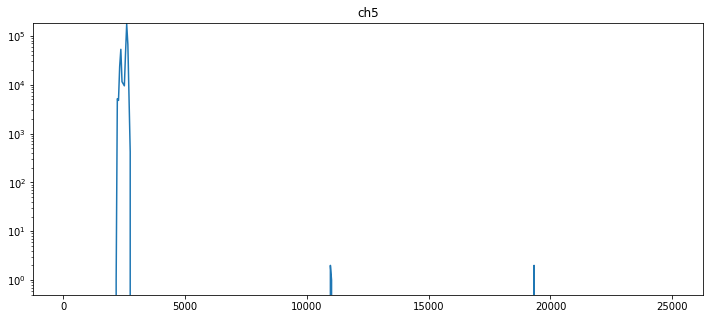

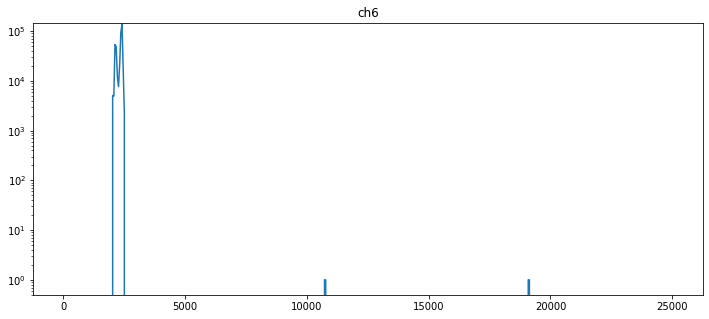

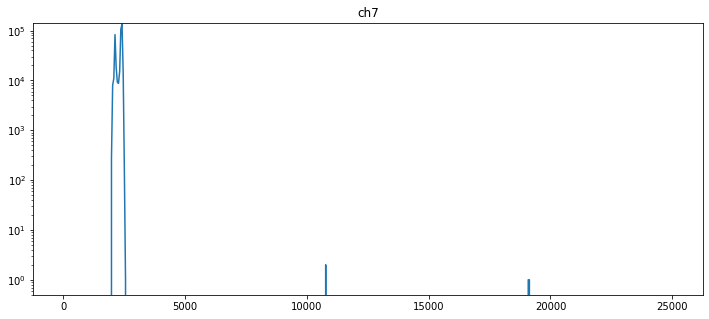

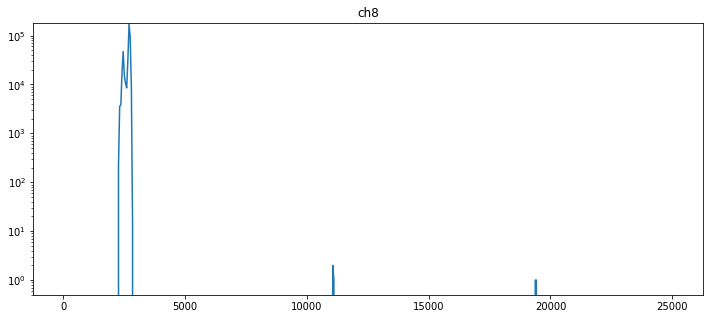

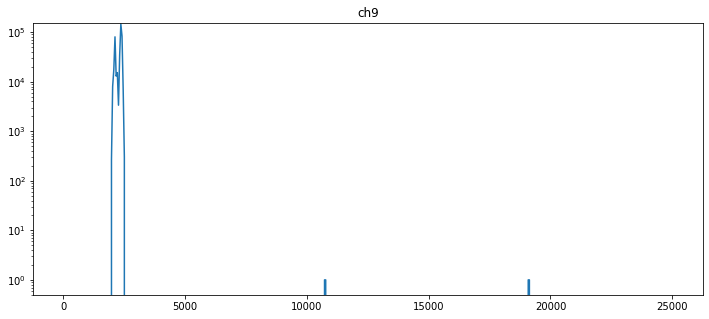

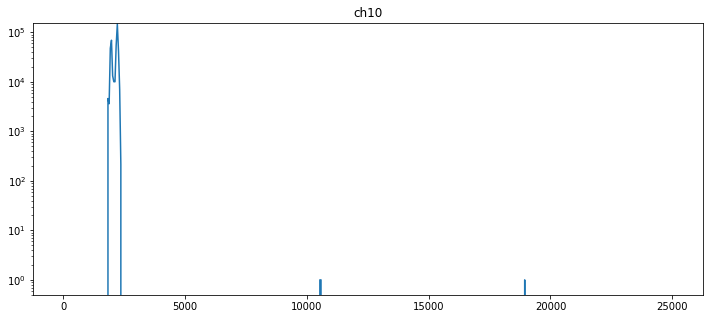

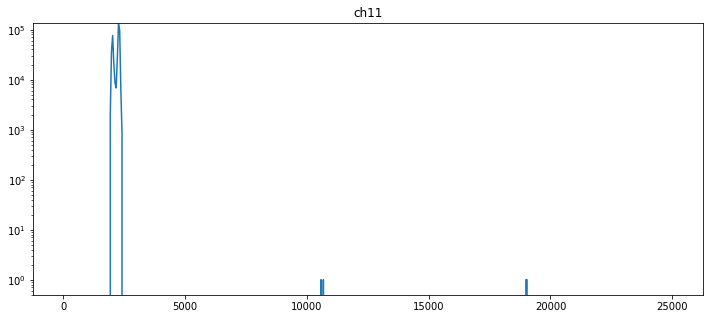

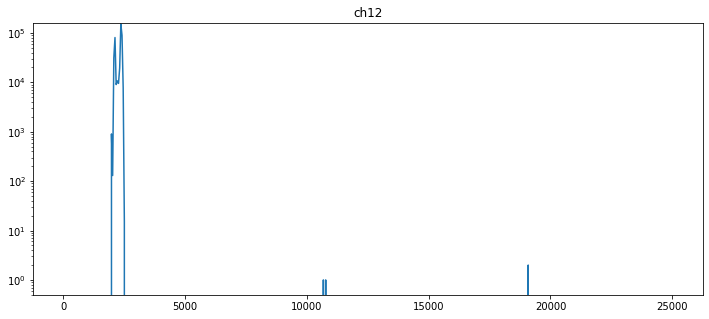

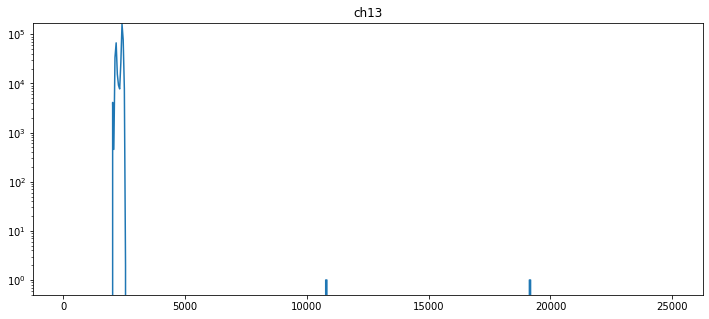

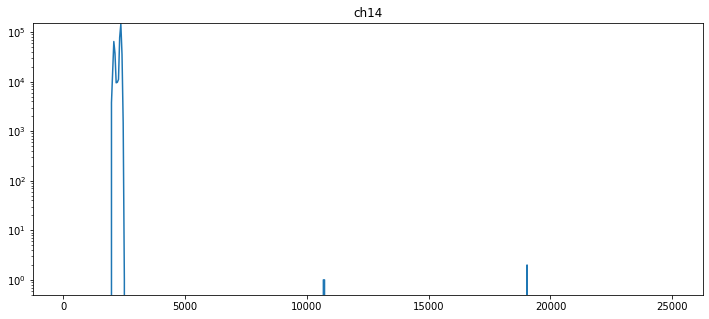

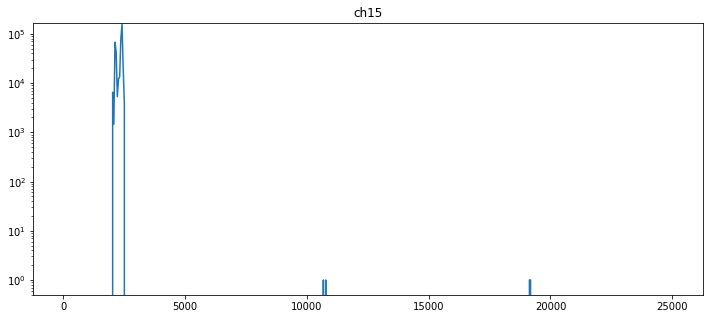

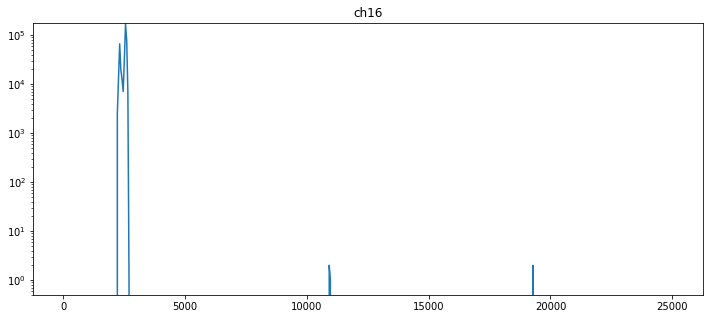

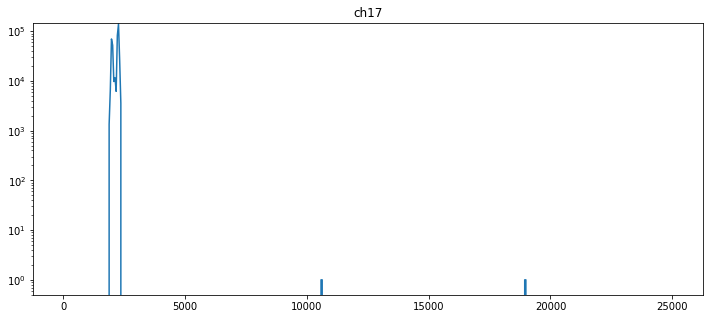

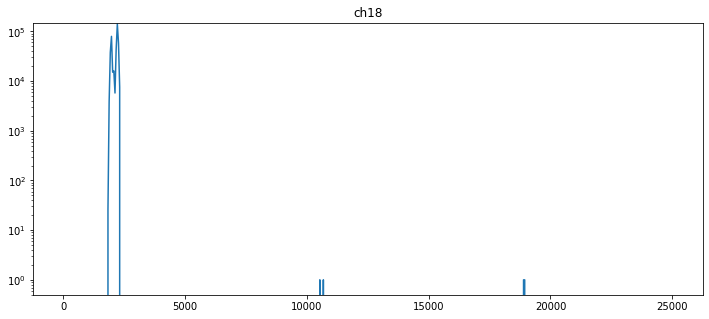

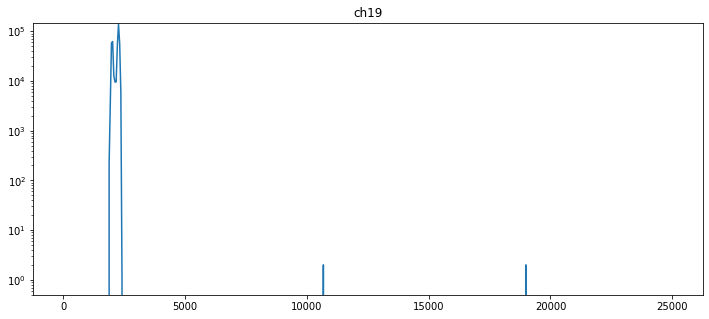

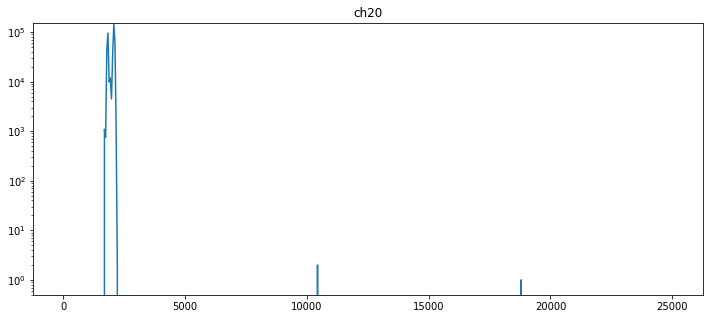

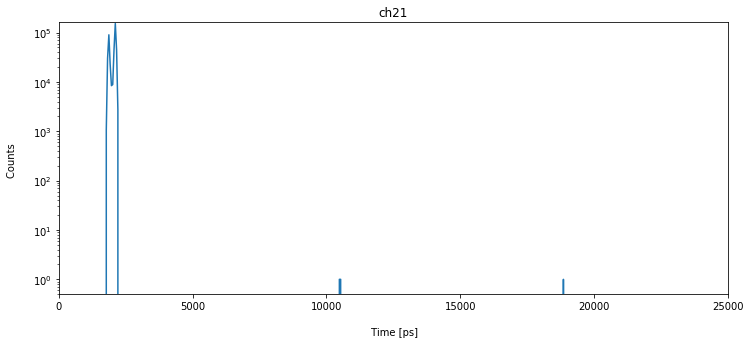

<Figure size 1800x720 with 0 Axes>

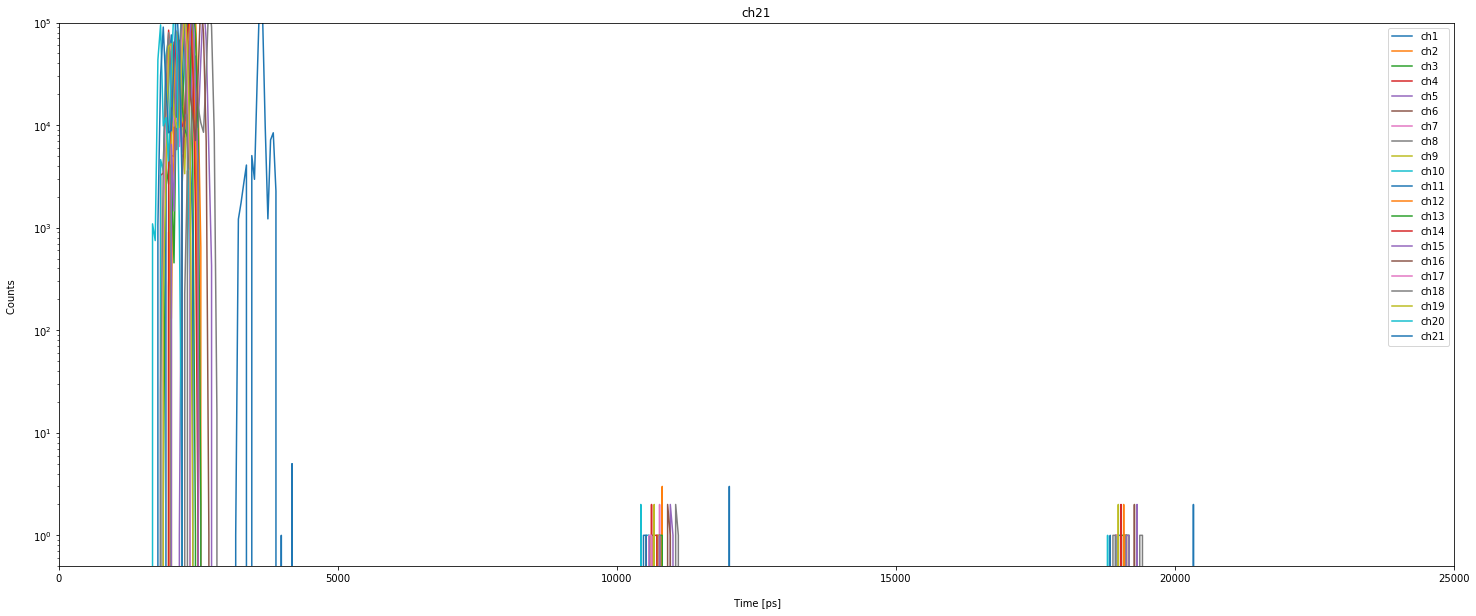

In [75]:
figure(figsize(12,5))
fig=plt.figure()
b={}
decay={}
nbins=int(round(laser_ps/kC4))
x=linspace(0,laser_ps,nbins)
for k in tqdm(range(nchannel)):
    try:
        decay[k],b[k]=histogram(np.flip(dt_mod[k]), range=[0,laser_ps],bins=nbins)
        decay[k]=np.flip(decay[k])
        figure()   
        plot(x,decay[k][:],label='ch'+str(k+1))  
        title('ch'+str(k+1))
        ylim(0.5,)
        yscale("log")
    except:
        print("Error ", i)    
xlim(0,laser_ps)
xlabel('\n Time [ps]')
ylabel('Counts \n')

figure(figsize(25,10))
fig=plt.figure()
b={}
decay={}
nbins=int(round(laser_ps/kC4))
x=linspace(0,laser_ps,nbins)
for k in tqdm(range(nchannel)):
    try:
        decay[k],b[k]=histogram(np.flip(dt_mod[k]), range=[0,laser_ps],bins=nbins)
        decay[k]=np.flip(decay[k])
        plot(x,decay[k][:],label='ch'+str(k+1))  
        title('ch'+str(k+1))
        ylim(0.5,)
        yscale("log")
    except:
        print("Error ", i)    
xlim(0,laser_ps)
xlabel('\n Time [ps]')
ylabel('Counts \n')
ylim(0.5,1e5)

legend()

(0.0, 20000000.0)

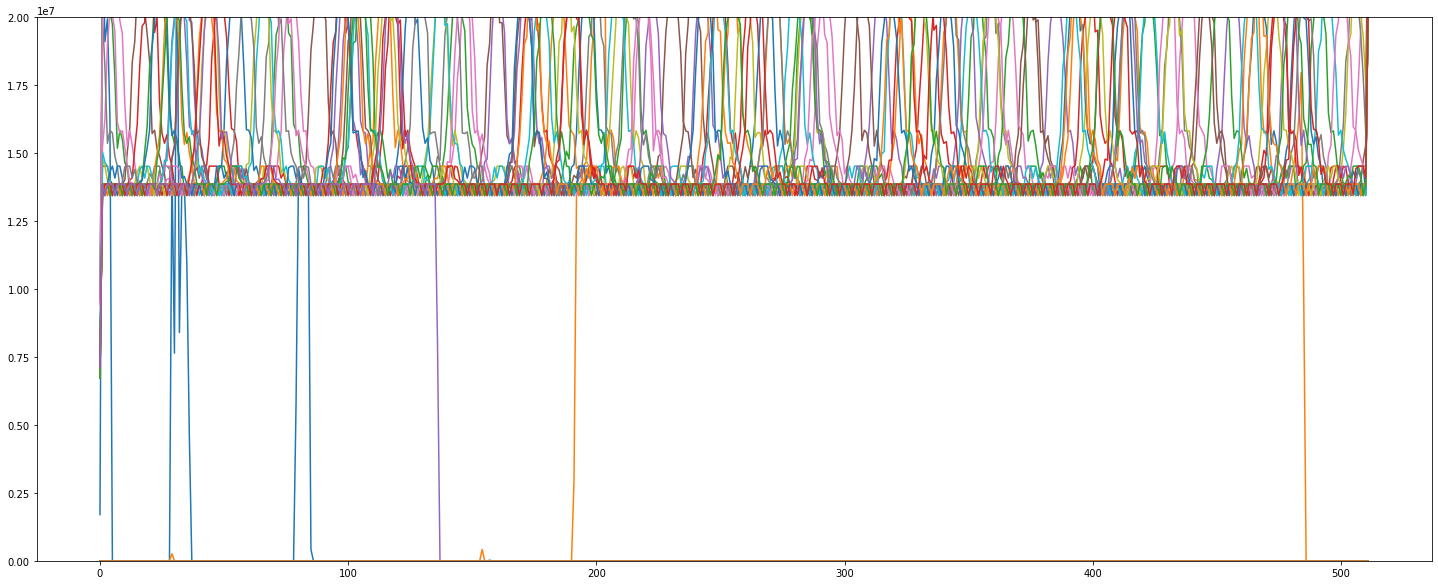

In [76]:
a=histogram2d(xx,yy, weights=dred["total_photon"],bins=[alfa,alfa],range=[[0,alfa],[0,alfa]])
plot(a[0][:,:]/50e-6)
ylim(0,2e7)

Skip ch 21
Skip ch 22
Skip ch 23
Skip ch 24
Skip ch 25
Skip ch 26
Skip ch 27
Skip ch 28
Skip ch 29
Skip ch 30
Skip ch 31
Skip ch 32
Skip ch 33
Skip ch 34
Skip ch 35
Skip ch 36
Skip ch 37
Skip ch 38
Skip ch 39
Skip ch 40
Skip ch 41
Skip ch 42
Skip ch 43
Skip ch 44
Skip ch 45
Skip ch 46
Skip ch 47
Skip ch 48


<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

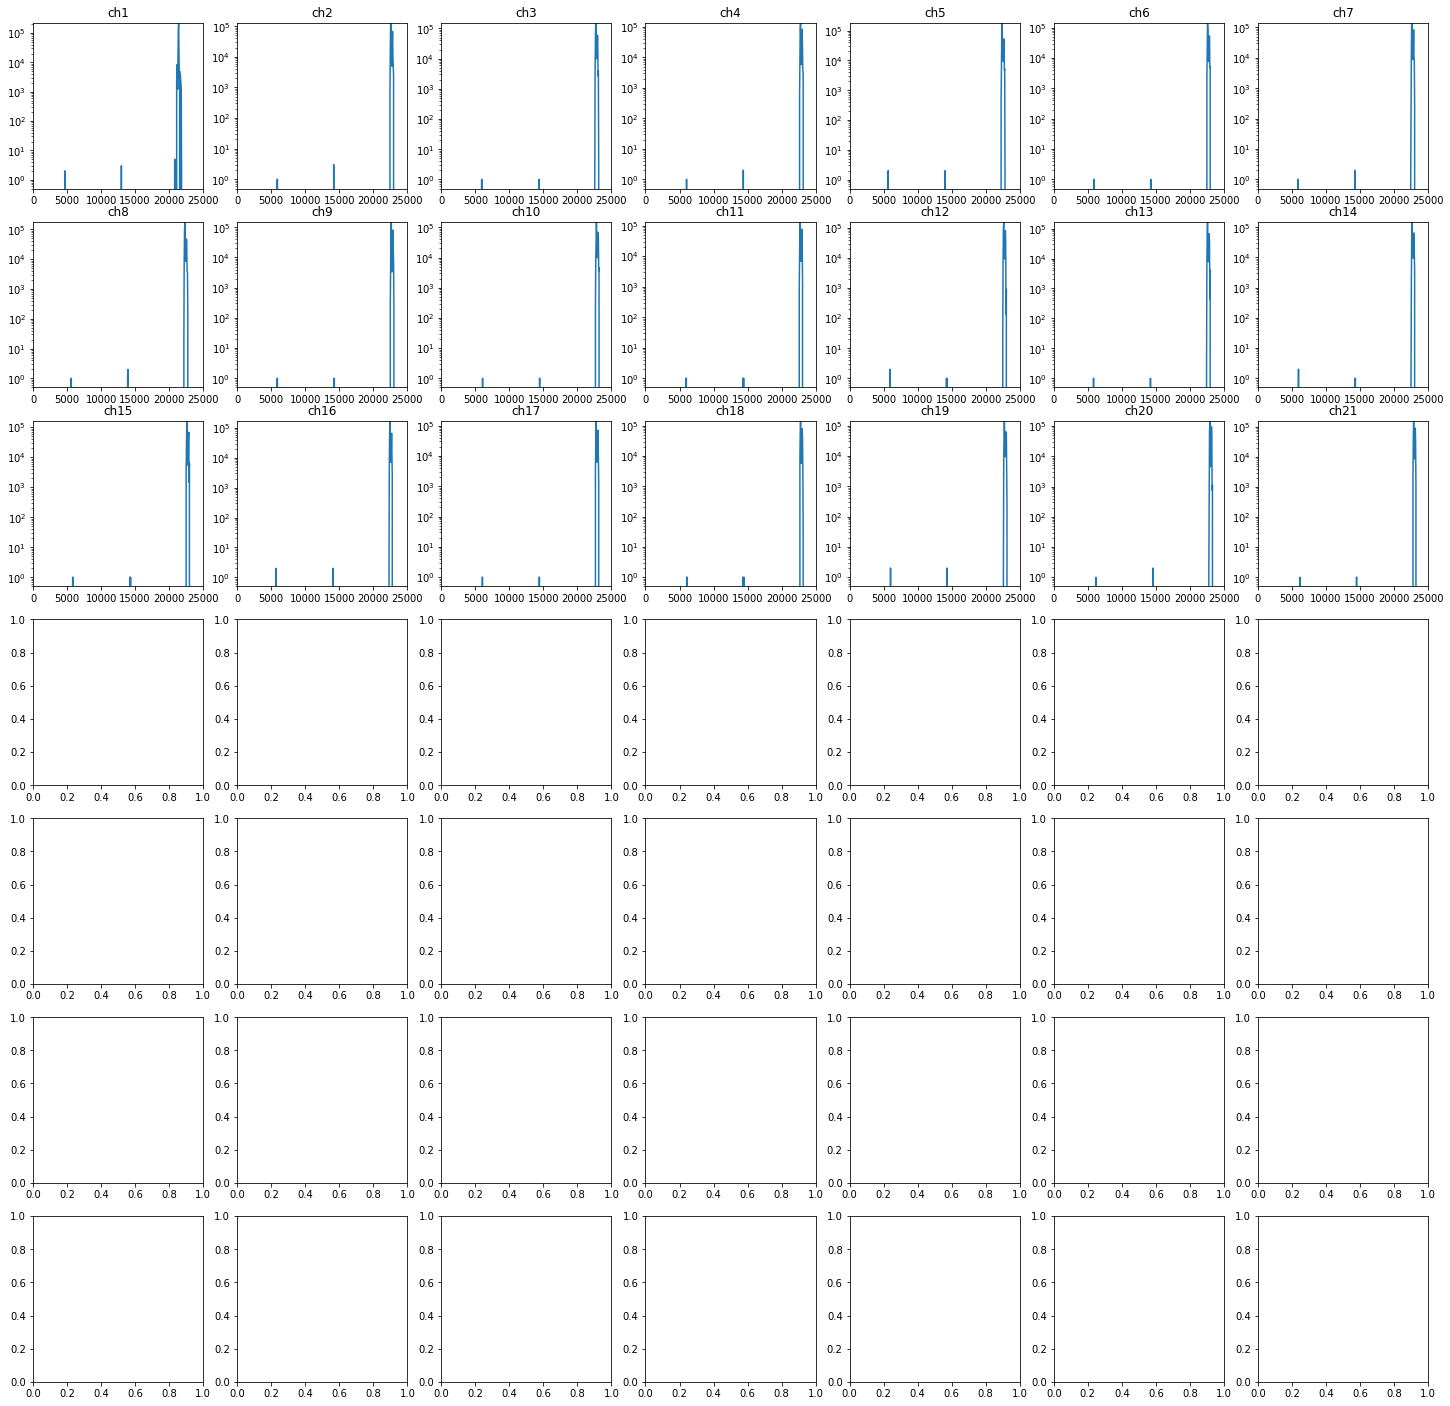

In [77]:
figure(figsize(25,25))
fig=plt.figure()
b={}
decay={}
nbins=int(round(laser_ps/kC4))
x=linspace(0,laser_ps,nbins)

fig, axs = plt.subplots(7, 7)

for iy in range(0,7):
    for ix in range(0,7):
        ch=ix+iy*7
        try:
            decay=histogram(np.flip(dt_mod[ch]), range=[0,laser_ps],bins=nbins)[0]
            axs[iy, ix].plot(x,decay[:],label='ch'+str(k+1))  
            axs[iy, ix].set_title('ch'+str(ch+1))
            axs[iy, ix].set_ylim(0.5,)
            axs[iy, ix].set_xlim(0,laser_ps)
            axs[iy, ix].set_yscale("log")

        except:
            print("Skip ch",ch)
savefig("/tmp/decays.png")